In [42]:
# !pip install --upgrade pip

import os
from joblib import Parallel, delayed

from sklearn.ensemble import IsolationForest
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dataclasses
from dataclasses import asdict
from tqdm import tqdm
import warnings
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold # Feature selector

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns


# Global utitlity functions are in separate notebook
%run ./Classification_utility-functions.ipynb
%run ./SEED-CONSTANTS.ipynb

np.random.seed(SEED)
print(f"Numpy Seed was set to: {SEED}")

print("Setup Complete")

SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case
EER: 0.167, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.333, Threshold: 1.000 <-- Worse case
--------------------Utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Preprocessing utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Neural Networks utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER

In [43]:
import joblib
from joblib.parallel import effective_n_jobs

print(f"Total cpu count: {joblib.cpu_count()}")

# Get the number of available CPU cores
available_cores = effective_n_jobs(n_jobs=-1)

print(f"Available CPU cores: {available_cores}")


Total cpu count: 32
Available CPU cores: 32


In [44]:
@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Parameter set. Used as identifier for charts etc.
    frequency: int
    max_subjects: int
    max_test_subjects: int
        
    user_ids: list
    num_sample_points_per_exp: int
    exp_begin_cutoff_idx: int
    exp_end_cutoff_idx: int
        
    
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    window_size: int  # After resampling
    step_width: int  # After resampling
    scaler: str  # StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler, PowerTransformer
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # fit transform scale on all data (True) or fit on training only (False)
    IF_kernel: str # IF kernel
    IF_nu: float  # Best value found in random search, used for final model
    IF_gamma: float  # Best value found in random search, used for final model
    feature_cols: list  # Columns used as features
    exclude_subjects: list  # Don't load data from those users
        
    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        

# INSTANCES
# ===========================================================

# NAIVE_APPROACH
# -----------------------------------------------------------
NAIVE_MINMAX_IF = ExperimentParameters(
    name="NAIVE-MINMAX_IF",
    frequency=100,
    max_subjects=29,
    max_test_subjects=10,
    user_ids = [1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49],
    num_sample_points_per_exp=21000,
    exp_begin_cutoff_idx=500,
    exp_end_cutoff_idx=-500,
    seconds_per_subject_train=210,
    seconds_per_subject_test=210,    
    window_size=250,
    step_width=250,
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    IF_kernel="rbf",
    IF_nu=None,
    IF_gamma=None,
    feature_cols=[
        "EMA_x_a",
        "EMA_y_a",
        "EMA_z_a",
        "EMA_x_g",
        "EMA_y_g",
        "EMA_z_g",
    ],
    exclude_subjects=[],
)

# VALID_APPROACH
# -----------------------------------------------------------
VALID_MINMAX_IF = dataclasses.replace(
    NAIVE_MINMAX_IF,
    name="VALID-MINMAX-IF",
    scaler_global=False,
    IF_nu=0.165,
    IF_gamma=0.039,
)

# NAIVE_ROBUST_APPROACH
# -----------------------------------------------------------
NAIVE_ROBUST_IF = dataclasses.replace(
    NAIVE_MINMAX_IF,
    name="NAIVE-ROBUST-IF",
    scaler="robust",
    scaler_global=True,
    IF_nu=0.153,
    IF_gamma=0.091,  # below median, selected by chart
)

# ROBUST_APPROACH (VALID)
# -----------------------------------------------------------
VALID_ROBUST_IF_125 = dataclasses.replace(
    NAIVE_MINMAX_IF,
    name="VALID-ROBUST-IF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=125
#     IF_nu=0.037,
#     IF_gamma= 0.001,
)


VALID_ROBUST_IF_250 = dataclasses.replace(
    NAIVE_MINMAX_IF,
    name="VALID-ROBUST-IF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=250
#     IF_nu=0.037,
#     IF_gamma= 0.001,
)

VALID_ROBUST_IF_500 = dataclasses.replace(
    NAIVE_MINMAX_IF,
    name="VALID-ROBUST-IF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=500
#     IF_nu=0.037,
#     IF_gamma= 0.001,
)

VALID_ROBUST_IF_750 = dataclasses.replace(
    NAIVE_MINMAX_IF,
    name="VALID-ROBUST-IF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=750
#     IF_nu=0.037,
#     IF_gamma= 0.001,
)

VALID_ROBUST_IF_1000 = dataclasses.replace(
    NAIVE_MINMAX_IF,
    name="VALID-ROBUST-IF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1000
#     IF_nu=0.037,
#     IF_gamma= 0.001,
)

VALID_ROBUST_IF_1250 = dataclasses.replace(
    NAIVE_MINMAX_IF,
    name="VALID-ROBUST-IF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1250
#     IF_nu=0.037,
#    IF_gamma= 0.001,
)

VALID_ROBUST_IF_1500 = dataclasses.replace(
    NAIVE_MINMAX_IF,
    name="VALID-ROBUST-IF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1500
#     IF_nu=0.037,
#     IF_gamma= 0.001,
)

VALID_ROBUST_IF_1750 = dataclasses.replace(
    NAIVE_MINMAX_IF,
    name="VALID-ROBUST-IF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1750
#     IF_nu=0.037,
#     IF_gamma= 0.001,
)

VALID_ROBUST_IF_2000 = dataclasses.replace(
    NAIVE_MINMAX_IF,
    name="VALID-ROBUST-IF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=2000
#     IF_nu=0.037,
#     IF_gamma= 0.001,
)

# NORMALIZER_APPROACH (VALID)
# -----------------------------------------------------------
VALID_NORMALIZER_IF = dataclasses.replace(
    NAIVE_MINMAX_IF,
    name="VALID-NORMALIZER-IF",
    scaler="Normalizer",
    scaler_global=False,
    IF_nu=0.074,
    IF_gamma= 0.029,
)

In [45]:
P = VALID_ROBUST_IF_2000
P.step_width = int(P.window_size * .5)
P.classifier="IF"
# P = VALID_NORMALIZER_IF

In [46]:
utils_ppp(P)

,Value
name,VALID-ROBUST-IF
frequency,100
max_subjects,29
max_test_subjects,10
user_ids,"[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 2..."
num_sample_points_per_exp,21000
exp_begin_cutoff_idx,500
exp_end_cutoff_idx,-500
seconds_per_subject_train,210
seconds_per_subject_test,210


In [47]:
[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49][17]

37

In [48]:
utils_eer_scorer

make_scorer(utils_eer, greater_is_better=False)

# Split Dataset for Valid/Test  
In two splits: one used during hyperparameter optimization, and one used during testing.

The split is done along the subjects: All sessions of a single subject will either be in the validation split or in the testing split, never in both.

They did a 30 60 split.

# Reshaping Raw Features.
We have our own function of windows for this. Do this for both training and testing.

# Extracting time and frequency based features.
Again, we have a function for this. Do this for both training and testing.

# Hyperparameter Optimization 

I do not find any reaqsonable explaination how to use a cross-validation as we are talking about anomaly detection.

I am using the experiment 1 data as train, and experiment 2 data as validation.

# Using SVM in a real-world Scenario with multiple genuine users and intruders
Source: https://datascience.stackexchange.com/questions/23623/what-is-the-best-way-to-classify-data-not-belonging-to-set-of-classes

Stage 1: 
    Use one-class SVM to assign those images that do not belong to the set of predefined classes as the 9-th class.

Stage 2:
    For those images that passes through your filter, let the multi-class SVM assign them to one of the 8 classes.

Loading data:

In [49]:
P.user_ids

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 19,
 21,
 22,
 26,
 27,
 28,
 29,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 48,
 49]

In [50]:
#include 47 later
# user_ids = [9]
df_exps_dict = load_data_frames(P.user_ids, P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, P.num_sample_points_per_exp)
dfList_exp1, dfList_exp2 = df_exps_dict['dfList_exp1'], df_exps_dict['dfList_exp2']

Loading exp1 data:
1) accel_count: 28388, gyro_count: 31997
2) accel_count: 26010, gyro_count: 28954
3) accel_count: 28227, gyro_count: 31814
4) accel_count: 24860, gyro_count: 26105
5) accel_count: 24270, gyro_count: 24347
6) accel_count: 25012, gyro_count: 25060
7) accel_count: 25301, gyro_count: 25382
8) accel_count: 21975, gyro_count: 21658
19) accel_count: 24110, gyro_count: 25050
21) accel_count: 24326, gyro_count: 23809
22) accel_count: 29123, gyro_count: 28724
26) accel_count: 23148, gyro_count: 24291
27) accel_count: 24299, gyro_count: 23589
28) accel_count: 23807, gyro_count: 24523
29) accel_count: 24030, gyro_count: 23457
35) accel_count: 24388, gyro_count: 23673
36) accel_count: 24228, gyro_count: 24208
37) accel_count: 31945, gyro_count: 31816
38) accel_count: 22135, gyro_count: 22327
39) accel_count: 23573, gyro_count: 23459
40) accel_count: 23057, gyro_count: 24296
41) accel_count: 24102, gyro_count: 23681
42) accel_count: 24074, gyro_count: 24328
43) accel_count: 22631,

In [51]:
raw_dfList_exp1 = dfList_exp1
raw_dfList_exp2 = dfList_exp2

<AxesSubplot:>

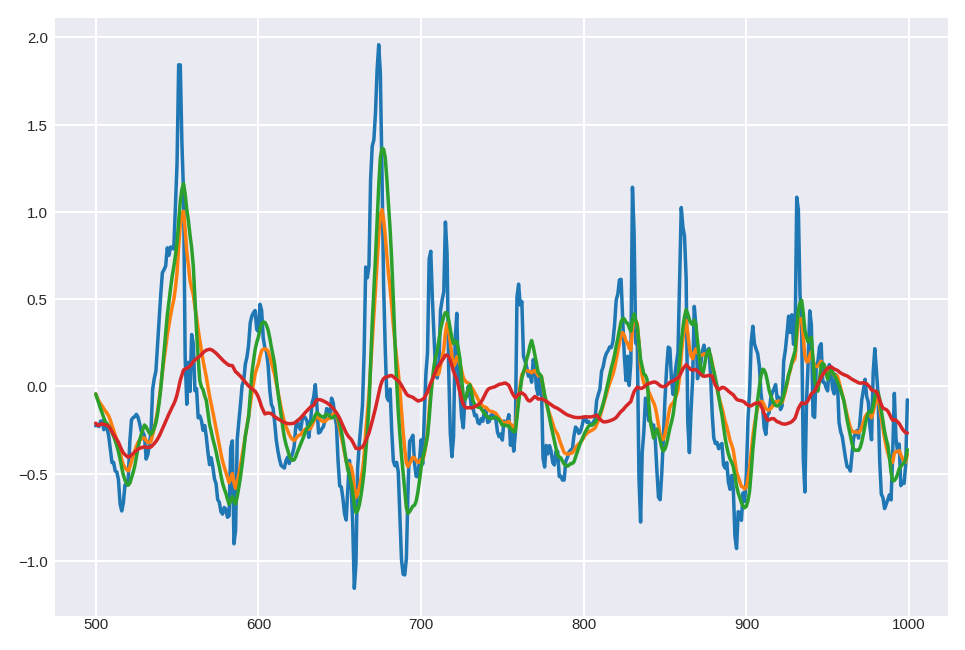

In [52]:
P.span=15
P.smoothing = "FFT+EMA"
# raw_dfList_exp1 = dfList_exp1
# raw_dfList_exp2 = dfList_exp2
P.cut_off_freq=42
ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=10)
ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=10)
ffted_dfList_exp2[0]['x_a'][500:1000].plot()
EMAed_dfList_exp1 = get_EMAed_dfList(ffted_dfList_exp1, span=P.span)
EMAed_dfList_exp2 = get_EMAed_dfList(ffted_dfList_exp2, span=P.span)
EMAed_dfList_exp2[0]['x_a'][500:1000].plot()

dfList_exp1 = ffted_dfList_exp1
dfList_exp2 = ffted_dfList_exp2

dfList_exp1 =EMAed_dfList_exp1
dfList_exp2 =EMAed_dfList_exp2

SMAed_dfList_exp1 = get_SMAed_dfList(ffted_dfList_exp1, winsize=10)
SMAed_dfList_exp2 = get_SMAed_dfList(ffted_dfList_exp2, winsize=10)
SMAed_dfList_exp2[0]['x_a'][500:1000].plot()

raw_dfList_exp2[0]['x_a'][500:1000].rolling(window=50, min_periods=0).mean().plot()

In [53]:
randomized_data_idx = list(range(len(P.user_ids)))
random.Random(SEED).shuffle(randomized_data_idx)
split_idx = 2 * (len(randomized_data_idx)//3) + 1
train_set = randomized_data_idx[: split_idx]
test_set = randomized_data_idx[split_idx: ]
print(f"train_set: {train_set}\ntest_set: {test_set}")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


Loading exp1 data:
47) accel_count: 22777, gyro_count: 22226
Loading exp2 data:
47) accel_count: 17718, gyro_count: 18353


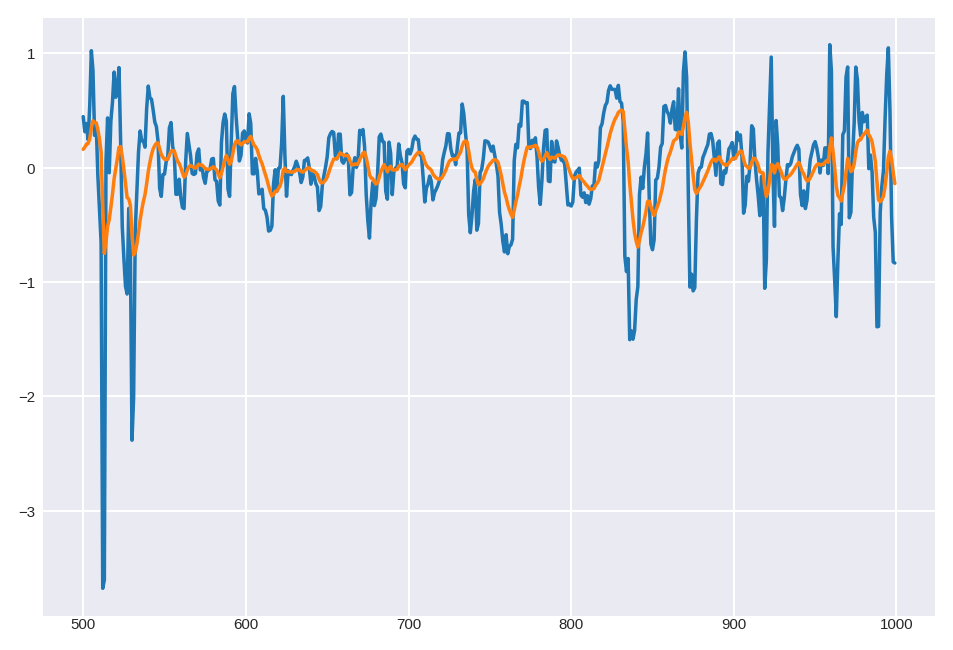

SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case
EER: 0.167, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.333, Threshold: 1.000 <-- Worse case
--------------------Utility functions imported--------------------
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
user_47_idx: 29
np.unique(all_user_set): [ 1  2  3  4  5  6  7  8 19 21 22 26 27 28 29 35 36 37 38 39 40 41 42 43
 44 45 46 48 49]
X_exp1_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
X_exp2_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
fitted_scaler_

In [54]:
num_sample_points_per_exp_user_47 = 18000
df_exps_dict_user_47 = load_data_frames([47], P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, num_sample_points_per_exp_user_47)
dfList_exp1_user_47, dfList_exp2_user_47 = df_exps_dict_user_47['dfList_exp1'], df_exps_dict_user_47['dfList_exp2']

raw_dfList_exp1_user_47 = dfList_exp1_user_47
raw_dfList_exp2_user_47 = dfList_exp2_user_47

ffted_dfList_exp1_user_47 = get_ffted_dfList(raw_dfList_exp1_user_47, cut_off_freq=P.cut_off_freq, filter_order=10, filtfilt=1)
ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=10, filtfilt=1)
ffted_dfList_exp2_user_47[0]['x_a'][500:1000].plot()

dfList_exp1_user_47 = ffted_dfList_exp1_user_47
dfList_exp2_user_47 = ffted_dfList_exp2_user_47

EMAed_dfList_exp1_user_47 = get_EMAed_dfList(ffted_dfList_exp1_user_47, span=P.span)
EMAed_dfList_exp2_user_47 = get_EMAed_dfList(ffted_dfList_exp2_user_47, span=P.span)
EMAed_dfList_exp2_user_47[0]['x_a'][500:1000].plot()

dfList_exp1_user_47 = EMAed_dfList_exp1_user_47
dfList_exp2_user_47 = EMAed_dfList_exp2_user_47

%run ./utility-functions.ipynb


# preparing train data
X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, P.window_size, P.step_width, train_set, 
                                                                    P.scaler, P.num_sample_points_per_exp, EMA_per_win_span=None, SMA_per_win_winsize=None)

X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47=get_raw_windows_user_47(dfList_exp1_user_47, dfList_exp2_user_47, P.window_size, P.step_width, 
                                                                                                                    scaler=P.scaler, num_sample_points_per_exp=P.num_sample_points_per_exp, 
                                                                                                                    EMA_per_win_span=None, SMA_per_win_winsize=None)

X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=append_user_47_to_data(X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict, P.user_ids, 
                                                                                           X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47, verbose=1)

print(f"len(exp1_df_train_dict): {len(X_train_exp1_dict)}")
print(f"len(exp2_df_train_dict): {len(X_train_exp2_dict)}")


# preparing test data
X_test_exp1_dict, X_test_exp2_dict, fitted_scaler_test_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, P.window_size, P.step_width, test_set, 
                                                                    P.scaler, P.num_sample_points_per_exp, EMA_per_win_span=None, SMA_per_win_winsize=None)

print(f"len(X_test_exp1_dict): {len(X_test_exp1_dict)}")
print(f"len(X_test_exp2_dict): {len(X_test_exp2_dict)}")

In [55]:
import joblib
joblib.cpu_count()

32

In [56]:
P.Butter_per_win_argdict={
                        "filter_order": 10,
                        "cut_off_freq": 27,
                        "sampling_freq": 100,
                        "filtfilt": 1,
                        }
P.Butter_per_win_argdict=None
EMA_per_win_span=None
SMA_per_win_winsize=None
fitted_scaler_train_exp2_dict_user_47
fitted_scaler_train_exp2_dict


overlap=.5
window_size=2000
step_width = int(window_size * (1-overlap))
X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, window_size, step_width, train_set, P.scaler, P.num_sample_points_per_exp, 
                                                                                    EMA_per_win_span=EMA_per_win_span, SMA_per_win_winsize=SMA_per_win_winsize, Butter_per_win_argdict=P.Butter_per_win_argdict)

X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47=get_raw_windows_user_47(dfList_exp1_user_47, dfList_exp2_user_47, window_size, step_width, scaler=P.scaler, 
                                                                                                                    num_sample_points_per_exp=P.num_sample_points_per_exp, EMA_per_win_span=EMA_per_win_span,
                                                                                                                    SMA_per_win_winsize=SMA_per_win_winsize, Butter_per_win_argdict=P.Butter_per_win_argdict)

X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict=append_user_47_to_data(X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict, P.user_ids, 
                                                                                           X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_train_exp2_dict_user_47, verbose=1)

X_exp_train_dic = extract_WACA_features(X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_train_exp2_dict)


len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
user_47_idx: 29
np.unique(all_user_set): [ 1  2  3  4  5  6  7  8 19 21 22 26 27 28 29 35 36 37 38 39 40 41 42 43
 44 45 46 48 49]
X_exp1_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
X_exp2_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
fitted_scaler_exp2_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
MakeWACAXExpDicOwner Time:  3.0787904523313046
MakeWACAXExpDicUnknown Time:  6.613893803209066
Done extracting features


In [57]:
param_dist = {"model__n_estimators": np.linspace(50, 200, num=10, dtype=np.int64),
              'model__max_samples':  np.arange(0.1, 1.1, 0.1),
              'model__contamination': np.arange(0.01, 0.11, 0.01),
              'model__max_features': np.arange(0.1, 1.1, 0.1),
              # 'model__bootstrap': [True, False], 
              }
dfList_dict={"dfList_exp1": raw_dfList_exp1,
            "dfList_exp2": raw_dfList_exp2,
            "dfList_exp1_user_47": raw_dfList_exp1_user_47,
            "dfList_exp2_user_47": raw_dfList_exp2_user_47,}
# EER_distro_df=calculate_EER_different_window_sizes_train_OCSVM_IF(dfList_dict, window_size_lst=[2000], train_set=train_set, exp_config=P, 
#                                                                   extract_features_func=extract_WACA_features, overlap=.5, param_dist=param_dist)

In [58]:
EER_distro_df

NameError: name 'EER_distro_df' is not defined

In [ ]:
1

In [ ]:
X_vals_owner_idx['cv_splits'][2][1][55:]

In [ ]:
len(train_set)
np.logspace(-3, 3, 6)
# np.arange(0, 10, 10)
np.logspace(1, 1, num=10, dtype=np.int64)
np.linspace(0.001, 0.5, num=6)
X_exp_train_dic.keys()

In [ ]:
param_dist

In [ ]:
np.logspace(1, 2.7, num=10, dtype=np.int64)
np.linspace(50, 200, num=10, dtype=np.int64)
np.linspace(0, 1, num=10, dtype=np.float64)
np.arange(0.1, 1.1, 0.1)
np.arange(0.01, 0.11, 0.01)
np.linspace(50, 200, num=10, dtype=np.int64)

P.ocsvm_kernel=None
P.classifier="IF"
a = evaluate_owner_classifier_train_valid(7, X_exp_train_dic, SEED, run, param_dist, cores=1, exp_config=P, verbose=0) 
a

In [ ]:
1

In [59]:
# param_dist
param_dist = {
    "model__n_estimators": np.linspace(50, 200, num=10, dtype=np.int64),
    'model__max_samples':  np.arange(0.1, 1.1, 0.1),
    'model__contamination': np.arange(0.01, 0.11, 0.01),
    'model__max_features': np.arange(0.1, 1.1, 0.1),
    # 'model__bootstrap': [True, False], 
    }
# param_dist
param_dist = {
    "model__n_estimators": [10],
    'model__max_samples':  np.arange(0.1, 1.1, 0.1),
    'model__contamination': np.arange(0.01, 0.11, 0.01),
    'model__max_features': np.arange(0.1, 1.1, 0.1),
    # 'model__bootstrap': [True, False], 
    }

df_results = None  # Will be filled with randomsearch scores


# Don't need to loop over to find the best PCA.
for run in tqdm(range(3)):
        
    with parallel_backend('loky', n_jobs=-1):
        df_reports = Parallel(n_jobs=-1, verbose=100)(delayed(evaluate_owner_classifier_train_valid)(owner_key, X_exp_train_dic, SEED, run, param_dist, cores=1, exp_config=P, verbose=0) 
                                                      for owner_key in tqdm(
                                                          X_exp_train_dic.keys(),
                                                          desc=f"run: {run}",
                                                      ))
    df_results = pd.concat([df_results] + df_reports, sort=False, ignore_index=True)
    
df_results
#2000 win size
#100%|██████████| 3/3 [01:55<00:00, 38.45s/it] parallel CORES=-1
#100%|██████████| 3/3 [01:53<00:00, 37.92s/it] CORES=-1
#100%|██████████| 3/3 [00:49<00:00, 16.40s/it] parallel CORES=1

#250 win size
#100%|██████████| 3/3 [00:52<00:00, 17.46s/it] CORES=1
#100%|██████████| 3/3 [02:00<00:00, 40.21s/it]

run: 0: 100%|██████████| 20/20 [00:00<00:00, 90.85it/s][A

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done   2 out of  20 | elapsed:   33.1s remaining:  5.0min
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:   33.1s remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:   33.1s remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:   33.2s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:   33.2s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:   33.3s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   33.3s remaining:   49.9s
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:   33.3s remaining:   40.8s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:   33.4s remaining:   33.4s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   33.4s remaining:   27.3s
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:   33.4s remaining:   22.3s
[Parallel(n_jobs=-1)]: Done  13 out of  20 | el

 33%|███▎      | 1/3 [00:34<01:08, 34.07s/it]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   33.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   33.8s finished



run: 1: 100%|██████████| 20/20 [00:00<00:00, 8184.01it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done   2 out of  20 | elapsed:   32.2s remaining:  4.8min
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:   32.2s remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:   32.4s remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:   32.4s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:   32.5s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:   32.5s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   32.6s remaining:   48.9s
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:   32.6s remaining:   39.8s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:   32.6s remaining:   32.6s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   32.6s remaining:   26.7s
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:   32.7s remaining:   21.8s
[Parallel(n_jobs=-1)]: Done  13 out of  20 | el

run: 2: 100%|██████████| 20/20 [00:00<00:00, 25954.85it/s]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done   2 out of  20 | elapsed:   33.1s remaining:  5.0min
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:   33.1s remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:   33.2s remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:   33.2s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:   33.3s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:   33.3s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   33.4s remaining:   50.0s
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:   33.4s remaining:   40.8s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:   33.4s remaining:   33.4s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   33.4s remaining:   27.3s
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapse

100%|██████████| 3/3 [01:41<00:00, 33.73s/it]

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   34.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   34.1s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__max_samples,param_model__max_features,param_model__contamination,24_test_eer,8_test_eer,...,27_test_accuracy,5_test_accuracy,29_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,7_test_eer,7_test_accuracy
0,0.013757,0.000194,0.007141,0.000070,10,0.3,0.2,0.02,0.575,0.025,...,0.725,0.500,0.425,0.617105,0.184436,55,7,0,NaN,NaN
1,0.013644,0.000044,0.007151,0.000057,10,1.0,0.6,0.1,0.225,0.400,...,1.000,0.850,0.725,0.793421,0.098623,33,7,0,NaN,NaN
2,0.013448,0.000065,0.006991,0.000054,10,0.8,0.2,0.1,0.250,0.000,...,0.925,0.800,0.850,0.869737,0.082947,15,7,0,NaN,NaN
3,0.013519,0.000171,0.007228,0.000583,10,0.8,0.6,0.08,0.300,0.350,...,0.900,0.850,0.700,0.748684,0.121524,42,7,0,NaN,NaN
4,0.013437,0.000095,0.006938,0.000064,10,0.1,0.9,0.02,0.500,0.500,...,0.500,0.500,0.500,0.500000,0.000000,70,7,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,0.013427,0.000068,0.006862,0.000042,10,0.6,1.0,0.07,0.375,0.600,...,0.400,0.425,NaN,0.503947,0.140549,65,29,2,0.675,0.325
4796,0.013442,0.000075,0.006981,0.000043,10,0.6,0.5,0.05,0.050,0.200,...,0.900,0.925,NaN,0.825000,0.078220,3,29,2,0.250,0.750
4797,0.013538,0.000075,0.007057,0.000042,10,0.5,0.9,0.05,0.425,0.100,...,0.775,0.700,NaN,0.731579,0.138565,20,29,2,0.550,0.450
4798,0.013394,0.000055,0.006891,0.000046,10,0.5,0.3,0.06,0.400,0.250,...,0.725,0.850,NaN,0.740789,0.085536,15,29,2,0.325,0.675


In [60]:
type(df_results.param_model__n_estimators.median())

numpy.float64

In [ ]:
df_reports

In [ ]:
import sklearn

print('The scikit-learn version is {}.'.format(sklearn.__version__))


In [ ]:
pd.set_option('display.max_columns', None)
# df_results[df_results['run']==1 ].groupby('owner').head(40)[6*20:8*20]

In [ ]:
# len(df_results[(df_results.rank_test_eer == 1) & (df_results.rank_test_accuracy == 1)])
len(df_results[(df_results.rank_test_eer == 1)])

In [ ]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# df_results[(df_results.rank_test_eer == 1) & (df_results.rank_test_accuracy == 1)].groupby('owner').head(40)[:269]
df_results[(df_results.rank_test_eer == 1)].groupby('owner').head(232)

In [ ]:
1*19*3

In [ ]:
df_results[df_results["owner"] == 14].shape

In [ ]:
# df_results[df_results["owner"] == 14][ df_results["rank_test_eer"] == 1]

In [ ]:
display(
    df_results[df_results["rank_test_eer"] == 1]
    .sort_values("mean_test_eer")
    .head(30)
)

In [ ]:
# display(
#     df_results[df_results["rank_test_eer"] == 1][
#         [
#             "mean_fit_time",
#             "param_model__nu",
#             "param_model__gamma",
#             "mean_test_accuracy",
#             "std_test_accuracy",
#             "mean_test_eer",
#             "std_test_eer",
#         ]
#     ].describe()
# )



In [ ]:
print(df_results.param_model__n_estimators.unique())
print(df_results.param_model__max_samples.unique())
print(df_results.param_model__contamination.unique())
print(df_results.param_model__max_features.unique())
print(P.median_n_estimators, P.median_max_samples, P.median_contamination, P.median_max_features)

In [ ]:
utils_plot_randomsearch_results_IF(df_results, n_top=1)

0, −0.15
1, −0.12
2, −0.09
3, −0.06
4, −0.03
5, 0.00
['0.150', '0.120', '0.090', '0.060', '0.030', '0.000']
0, −0.15
1, −0.12
2, −0.09
3, −0.06
4, −0.03
5, 0.00
['0.150', '0.120', '0.090', '0.060', '0.030', '0.000']
0, −0.15
1, −0.12
2, −0.09
3, −0.06
4, −0.03
5, 0.00
['0.150', '0.120', '0.090', '0.060', '0.030', '0.000']
0, −0.15
1, −0.12
2, −0.09
3, −0.06
4, −0.03
5, 0.00
['0.150', '0.120', '0.090', '0.060', '0.030', '0.000']
0, −0.15
1, −0.12
2, −0.09
3, −0.06
4, −0.03
5, 0.00
['0.150', '0.120', '0.090', '0.060', '0.030', '0.000']
0, −0.15
1, −0.12
2, −0.09
3, −0.06
4, −0.03
5, 0.00
['0.150', '0.120', '0.090', '0.060', '0.030', '0.000']


(133, 0.7000000000000001, 0.060000000000000005, 0.5)

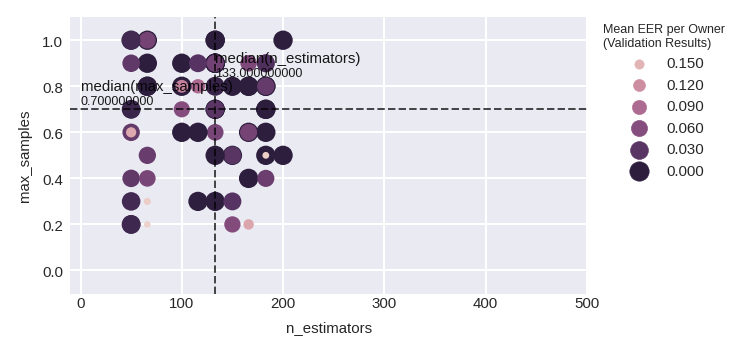

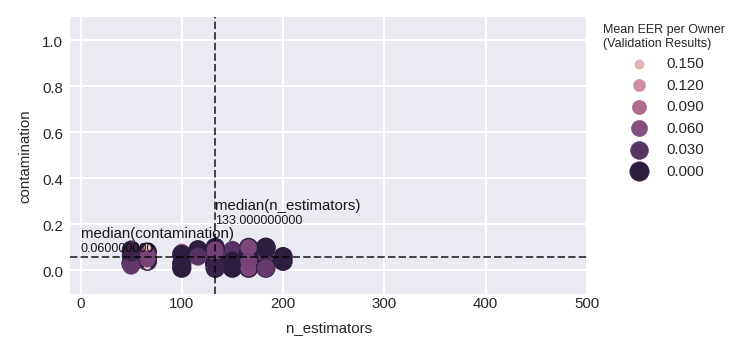

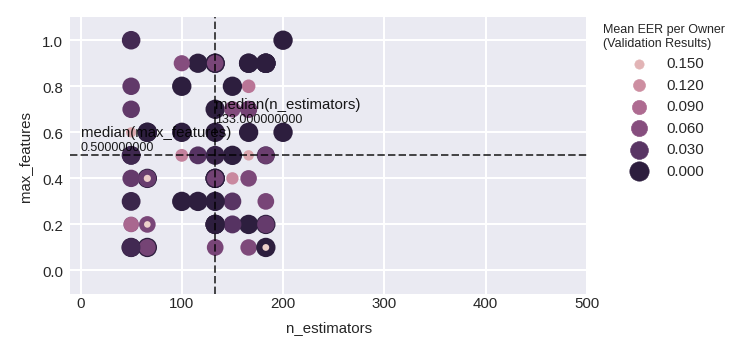

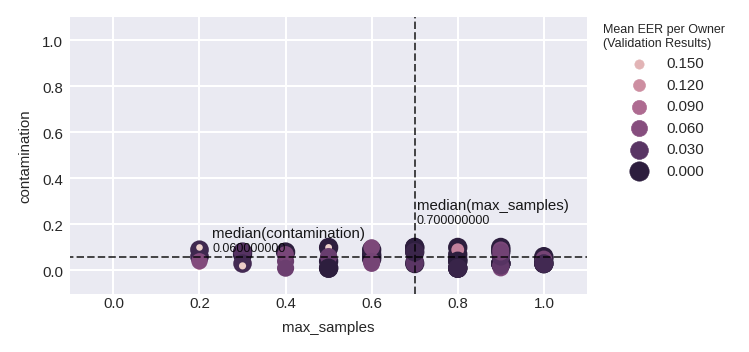

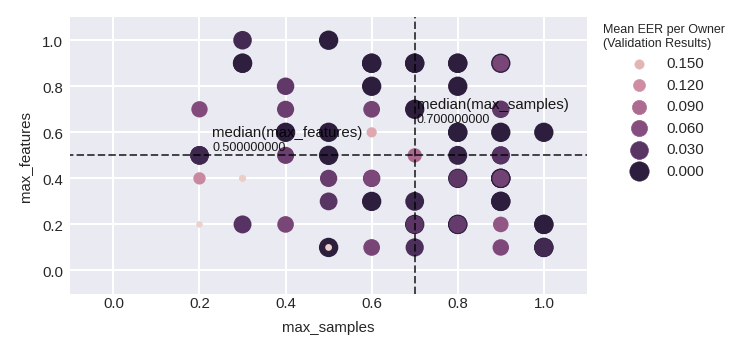

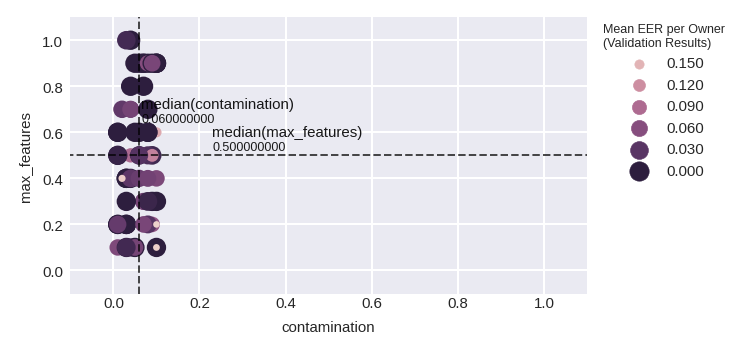

In [21]:
P.median_n_estimators = None 
P.median_max_samples = None
P.median_contamination = None
P.median_max_features = None
result_dict = utils_plot_randomsearch_results_IF(df_results, n_top=1, plot=True)
P.median_n_estimators, P.median_max_samples, P.median_contamination, P.median_max_features = \
            result_dict["median_n_estimators"], result_dict["median_max_samples"], result_dict["median_contamination"], result_dict["median_max_features"]

P.median_n_estimators = np.int64(np.round(P.median_n_estimators))

P.median_n_estimators, P.median_max_samples, P.median_contamination, P.median_max_features

In [22]:
# _, _, _, _, fig = utils_plot_randomsearch_results_IF(df_results, n_top=1)
# P.median_n_estimators, P.median_max_samples, P.median_contamination, P.median_max_features, fig = utils_plot_randomsearch_results_IF(df_results[(df_results.rank_test_eer == 1) & (df_results.mean_test_eer < 0.5)], n_top=1)
# plt.savefig(f'WACA-IF-Nu_Gamma_plot-win_size={P.window_size}-step_width={P.step_width}.png', bbox_inches='tight')
print(P.median_n_estimators, P.median_max_samples, P.median_contamination, P.median_max_features)

133 0.7000000000000001 0.060000000000000005 0.5


In [ ]:
print(f"median_n_estimators: {P.median_n_estimators},  median_max_samples: {P.median_max_samples},  median_contamination: {P.median_contamination},  median_max_features: {P.median_max_features}")

In [ ]:
P.median_max_features=P.median_max_features*84
print(P.median_n_estimators, P.median_max_samples, P.median_contamination, P.median_max_features)

In [ ]:
utils_ppp(P)

In [ ]:
# evaluate_owner_IF_train_test(2, X_exp_test_dic, SEED, run, param_dist, CORES=1)

In [ ]:
test_set
print(f"median_n_estimators: {P.median_n_estimators},  median_max_samples: {P.median_max_samples},  median_contamination: {P.median_contamination},  median_max_features: {P.median_max_features}")

In [ ]:
# param_dist
# P.median_n_estimators = 46 
# P.median_max_samples = 0.6
# P.median_contamination = 0.1
# P.median_max_features = 84

In [23]:
X_test_exp1_dict, X_test_exp2_dict, fitted_scaler_test_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, window_size, step_width, test_set, P.scaler, P.num_sample_points_per_exp, 
                                                                                    EMA_per_win_span=EMA_per_win_span, SMA_per_win_winsize=SMA_per_win_winsize, Butter_per_win_argdict=P.Butter_per_win_argdict)


X_exp_test_dic = extract_WACA_features(X_test_exp1_dict, X_test_exp2_dict, fitted_scaler_test_exp2_dict)

len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    1.4s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    1.4s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    1.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.5s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    1.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.7s finished
MakeWACAXExpDicOwner Time:  1.7356772497296333
[Parallel(n_jobs=-1)]: Using back

In [ ]:
test_set
# X_exp_test_dic

In [33]:
print(CORES)
# P.median_n_estimators=np.int64(P.median_n_estimators)
P.median_max_features=1.0

print(f"median_n_estimators: {P.median_n_estimators},  median_max_samples: {P.median_max_samples},  median_contamination: {P.median_contamination},  median_max_features: {P.median_max_features}")

-1
median_n_estimators: 133,  median_max_samples: 0.7000000000000001,  median_contamination: 0.060000000000000005,  median_max_features: 1.0


In [34]:
test_df_results = None  # Will be filled with randomsearch scores
for run in tqdm(range(5)):

    with parallel_backend('loky', n_jobs=-1):
        df_score = Parallel(n_jobs=-1, verbose=100)(delayed(evaluate_owner_classifier_train_test)(owner_key, X_exp_test_dic, SEED, run, cores=2, exp_config=P, verbose=0) 
                                                           for owner_key in tqdm(X_exp_test_dic.keys(),
                                                                                 desc=f"run: {run}",
                                                                                ))
    test_df_results = pd.concat([test_df_results] + df_score, sort=False, ignore_index=True, axis=0)

run: 0: 100%|██████████| 10/10 [00:00<00:00, 6159.04it/s]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    4.3s remaining:   17.0s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    4.3s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    4.3s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    4.3s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.4s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    4.4s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    4.5s remaining:    1.1s


 20%|██        | 1/5 [00:04<00:18,  4.62s/it]

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.6s finished



run: 1: 100%|██████████| 10/10 [00:00<00:00, 13005.59it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    4.2s remaining:   17.0s


 40%|████      | 2/5 [00:09<00:13,  4.54s/it]

[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    4.3s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    4.3s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    4.3s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.4s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    4.4s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    4.4s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.5s finished



run: 2: 100%|██████████| 10/10 [00:00<00:00, 6401.56it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    4.2s remaining:   16.8s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    4.2s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    4.3s remaining:    6.4s


 60%|██████    | 3/5 [00:13<00:09,  4.51s/it]

[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    4.3s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.3s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    4.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    4.4s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.5s finished



run: 3: 100%|██████████| 10/10 [00:00<00:00, 8858.09it/s]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    4.2s remaining:   16.8s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    4.2s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    4.2s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    4.3s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.3s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    4.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    4.4s remaining:    1.1s


 80%|████████  | 4/5 [00:17<00:04,  4.46s/it]

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.4s finished



run: 4: 100%|██████████| 10/10 [00:00<00:00, 8070.63it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    4.1s remaining:   16.3s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    4.2s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    4.2s remaining:    6.3s


100%|██████████| 5/5 [00:22<00:00,  4.47s/it]

[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    4.3s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.3s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    4.4s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    4.4s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.4s finished


In [35]:
test_df_results.head()
test_df_results.shape


(450, 10)

In [36]:
test_df_results

,fit_time,score_time,test_eer,test_accuracy,test_precision,test_recall,test_f1_score,owner,run,impostors
0,0.447016,0.585495,0.050,0.950,0.950000,0.95,0.950000,0,0,12
1,0.478303,0.480346,0.025,0.975,1.000000,0.95,0.974359,0,0,14
2,0.463821,0.507513,0.050,0.950,0.950000,0.95,0.950000,0,0,9
3,0.466342,0.546650,0.025,0.975,1.000000,0.95,0.974359,0,0,18
4,0.377368,0.438845,0.050,0.950,0.950000,0.95,0.950000,0,0,23
...,...,...,...,...,...,...,...,...,...,...
445,0.385643,0.415326,0.525,0.475,0.476190,0.50,0.487805,4,4,18
446,0.589695,0.406242,0.350,0.650,0.650000,0.65,0.650000,4,4,23
447,0.491441,0.439836,0.400,0.600,0.600000,0.60,0.600000,4,4,2
448,0.549912,0.376650,0.425,0.575,0.571429,0.60,0.585366,4,4,15


In [37]:
test_df_results.head()

,fit_time,score_time,test_eer,test_accuracy,test_precision,test_recall,test_f1_score,owner,run,impostors
0,0.447016,0.585495,0.050,0.950,0.95,0.95,0.950000,0,0,12
1,0.478303,0.480346,0.025,0.975,1.00,0.95,0.974359,0,0,14
2,0.463821,0.507513,0.050,0.950,0.95,0.95,0.950000,0,0,9
3,0.466342,0.546650,0.025,0.975,1.00,0.95,0.974359,0,0,18
4,0.377368,0.438845,0.050,0.950,0.95,0.95,0.950000,0,0,23


In [38]:
test_df_results.head()

,fit_time,score_time,test_eer,test_accuracy,test_precision,test_recall,test_f1_score,owner,run,impostors
0,0.447016,0.585495,0.050,0.950,0.95,0.95,0.950000,0,0,12
1,0.478303,0.480346,0.025,0.975,1.00,0.95,0.974359,0,0,14
2,0.463821,0.507513,0.050,0.950,0.95,0.95,0.950000,0,0,9
3,0.466342,0.546650,0.025,0.975,1.00,0.95,0.974359,0,0,18
4,0.377368,0.438845,0.050,0.950,0.95,0.95,0.950000,0,0,23


In [39]:
# mean_test_EER=test_df_results.groupby(['owner', 'impostors'], sort=False)[['fit_time', 'score_time', 'test_eer', 'train_eer', 'test_accuracy', 
#                                                                            'train_accuracy', 'test_precision', 'train_precision', 'test_recall',
#                                                                            'train_recall']].mean().reset_index()

mean_test_EER=test_df_results.groupby(['owner', 'impostors'], sort=False)[['fit_time', 'score_time', 'test_eer', 'test_accuracy', 
                                                                           'test_precision', 'test_recall', "test_f1_score"]].mean().reset_index()

mean_test_EER.test_eer.mean()

0.17894444444444446

In [40]:
test_df_plot = mean_test_EER.rename(
    columns={"test_f1_score": "Test F1_score","test_recall": "Test Recall" , "test_precision": "Test Precision", "test_accuracy": "Test Accuracy", "test_eer": "Test EER", "owner": "owner"}
).astype({"owner": str})
test_df_plot

,owner,impostors,fit_time,score_time,Test EER,Test Accuracy,Test Precision,Test Recall,Test F1_score
0,0,12,0.456754,0.500165,0.035,0.965,0.980000,0.95,0.964345
1,0,14,0.470983,0.525034,0.055,0.945,0.970000,0.92,0.943819
2,0,9,0.449275,0.589745,0.045,0.955,0.968947,0.94,0.954103
3,0,18,0.482154,0.491908,0.060,0.940,0.950426,0.93,0.939725
4,0,23,0.404213,0.484850,0.060,0.940,0.941429,0.94,0.940482
...,...,...,...,...,...,...,...,...,...
85,4,18,0.454857,0.397198,0.370,0.630,0.638528,0.61,0.622604
86,4,23,0.514450,0.422835,0.275,0.725,0.725167,0.73,0.727179
87,4,2,0.489670,0.400173,0.200,0.800,0.814365,0.78,0.796008
88,4,15,0.533647,0.420379,0.410,0.590,0.589048,0.60,0.594390


Overall mean: 0.1789
Overall mean: 0.8211
Overall mean: 0.8296
Overall mean: 0.8128
Overall mean: 0.8203


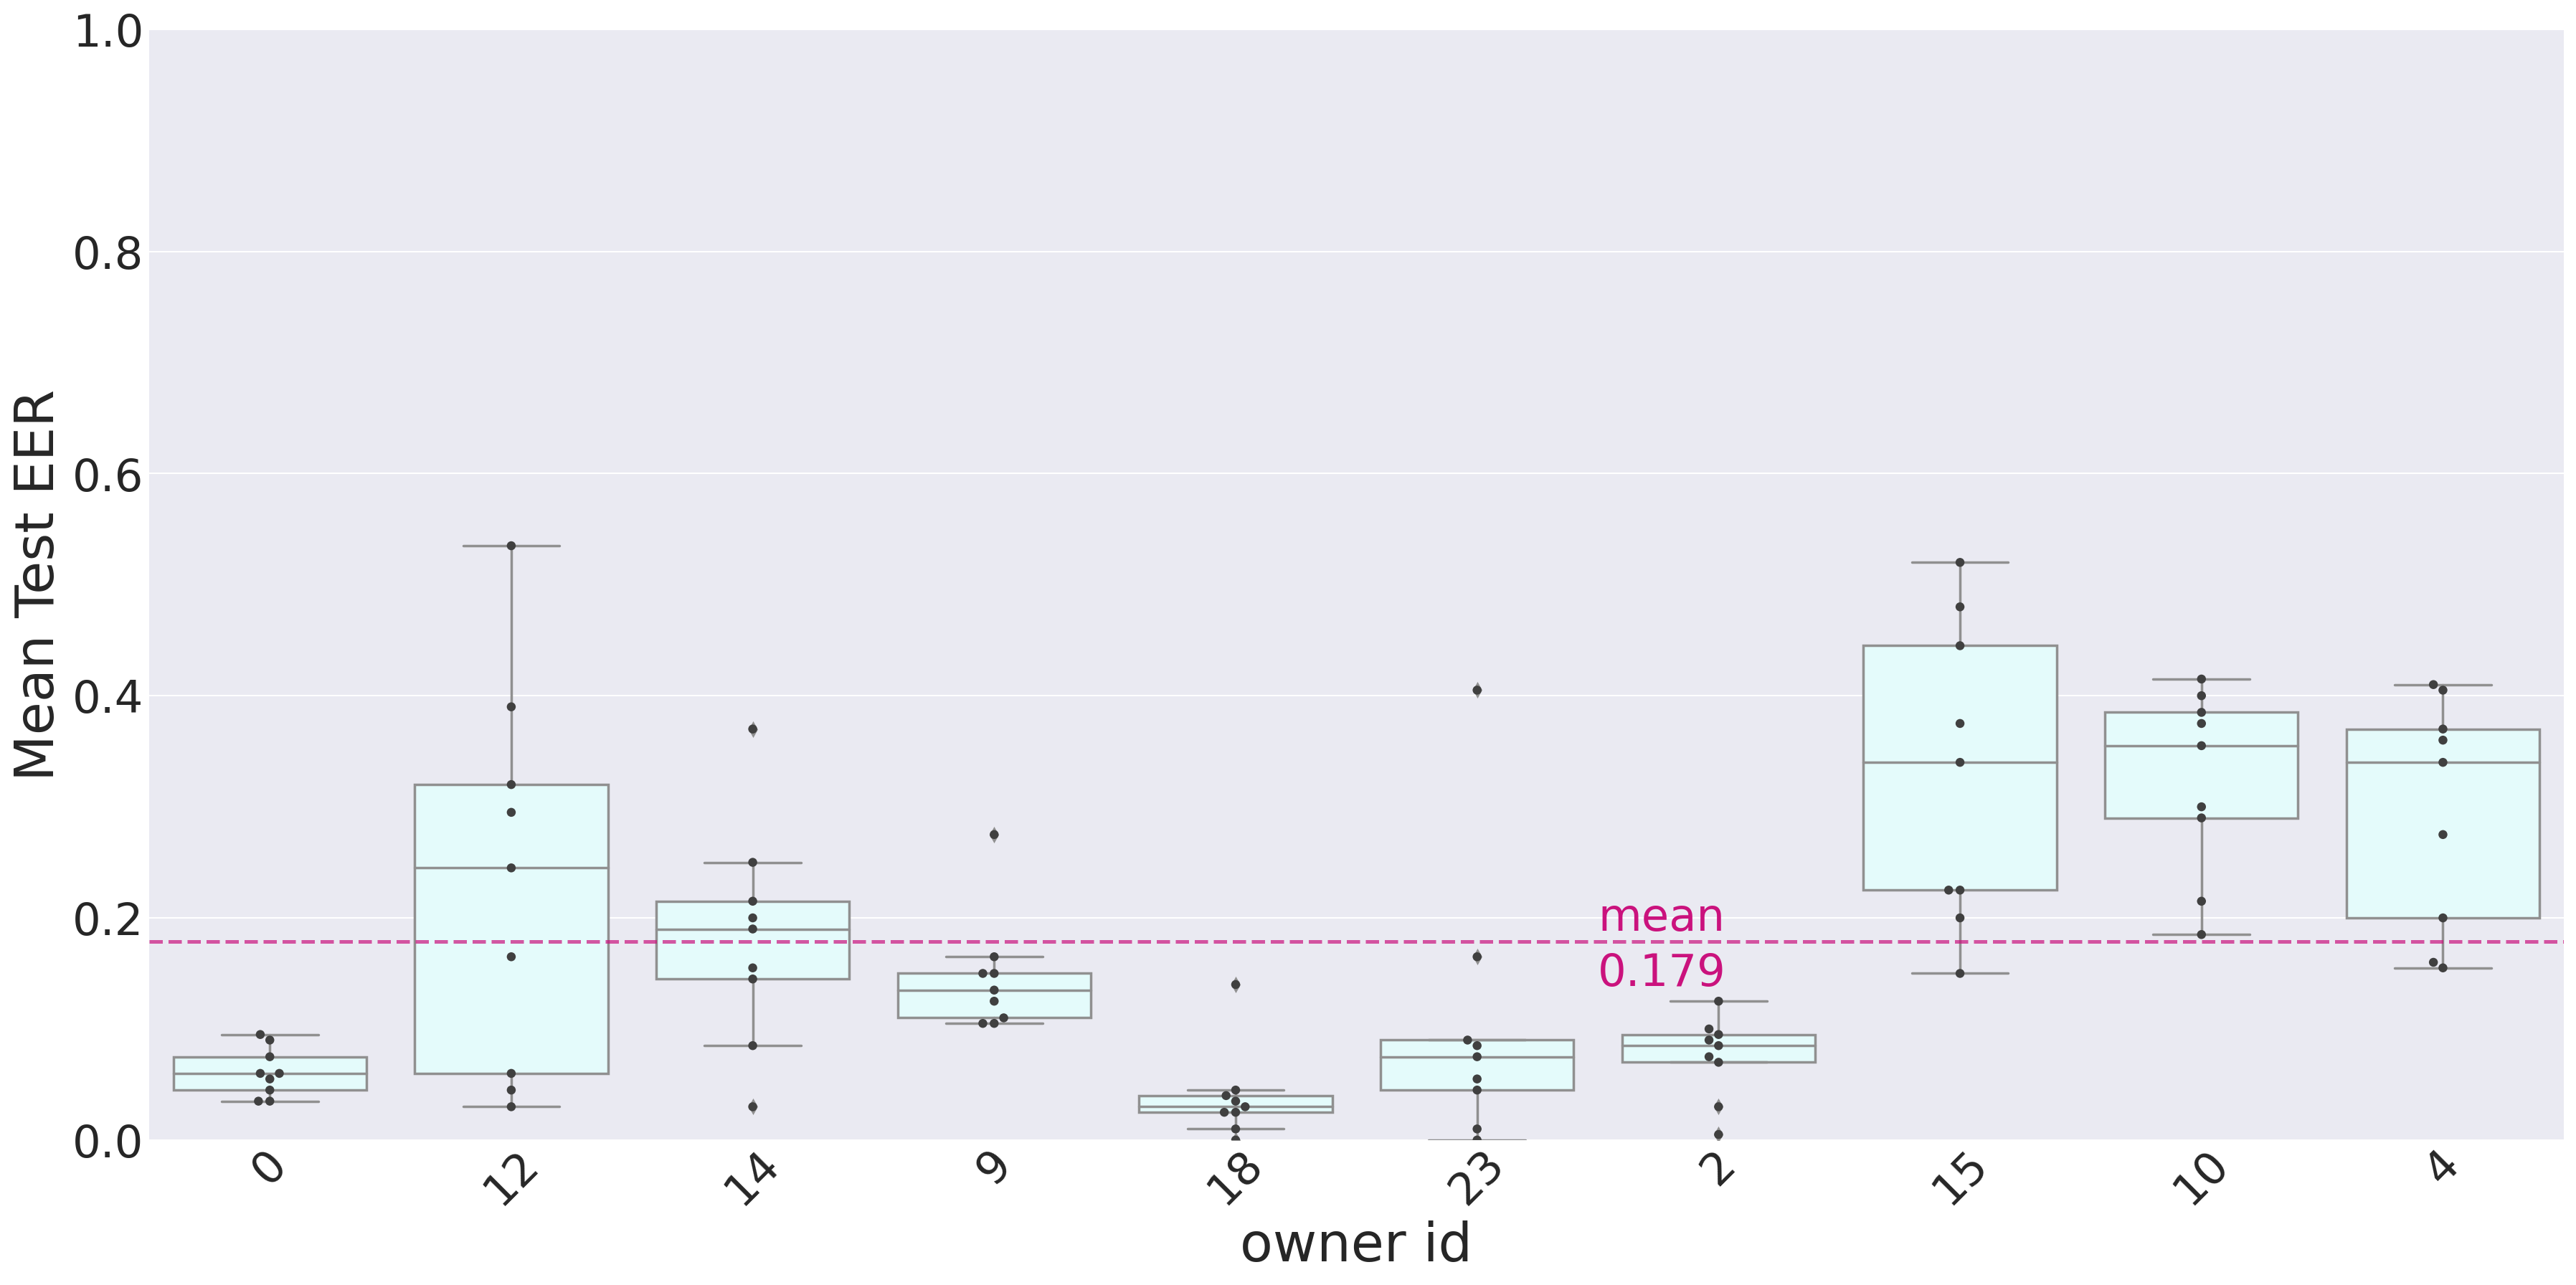

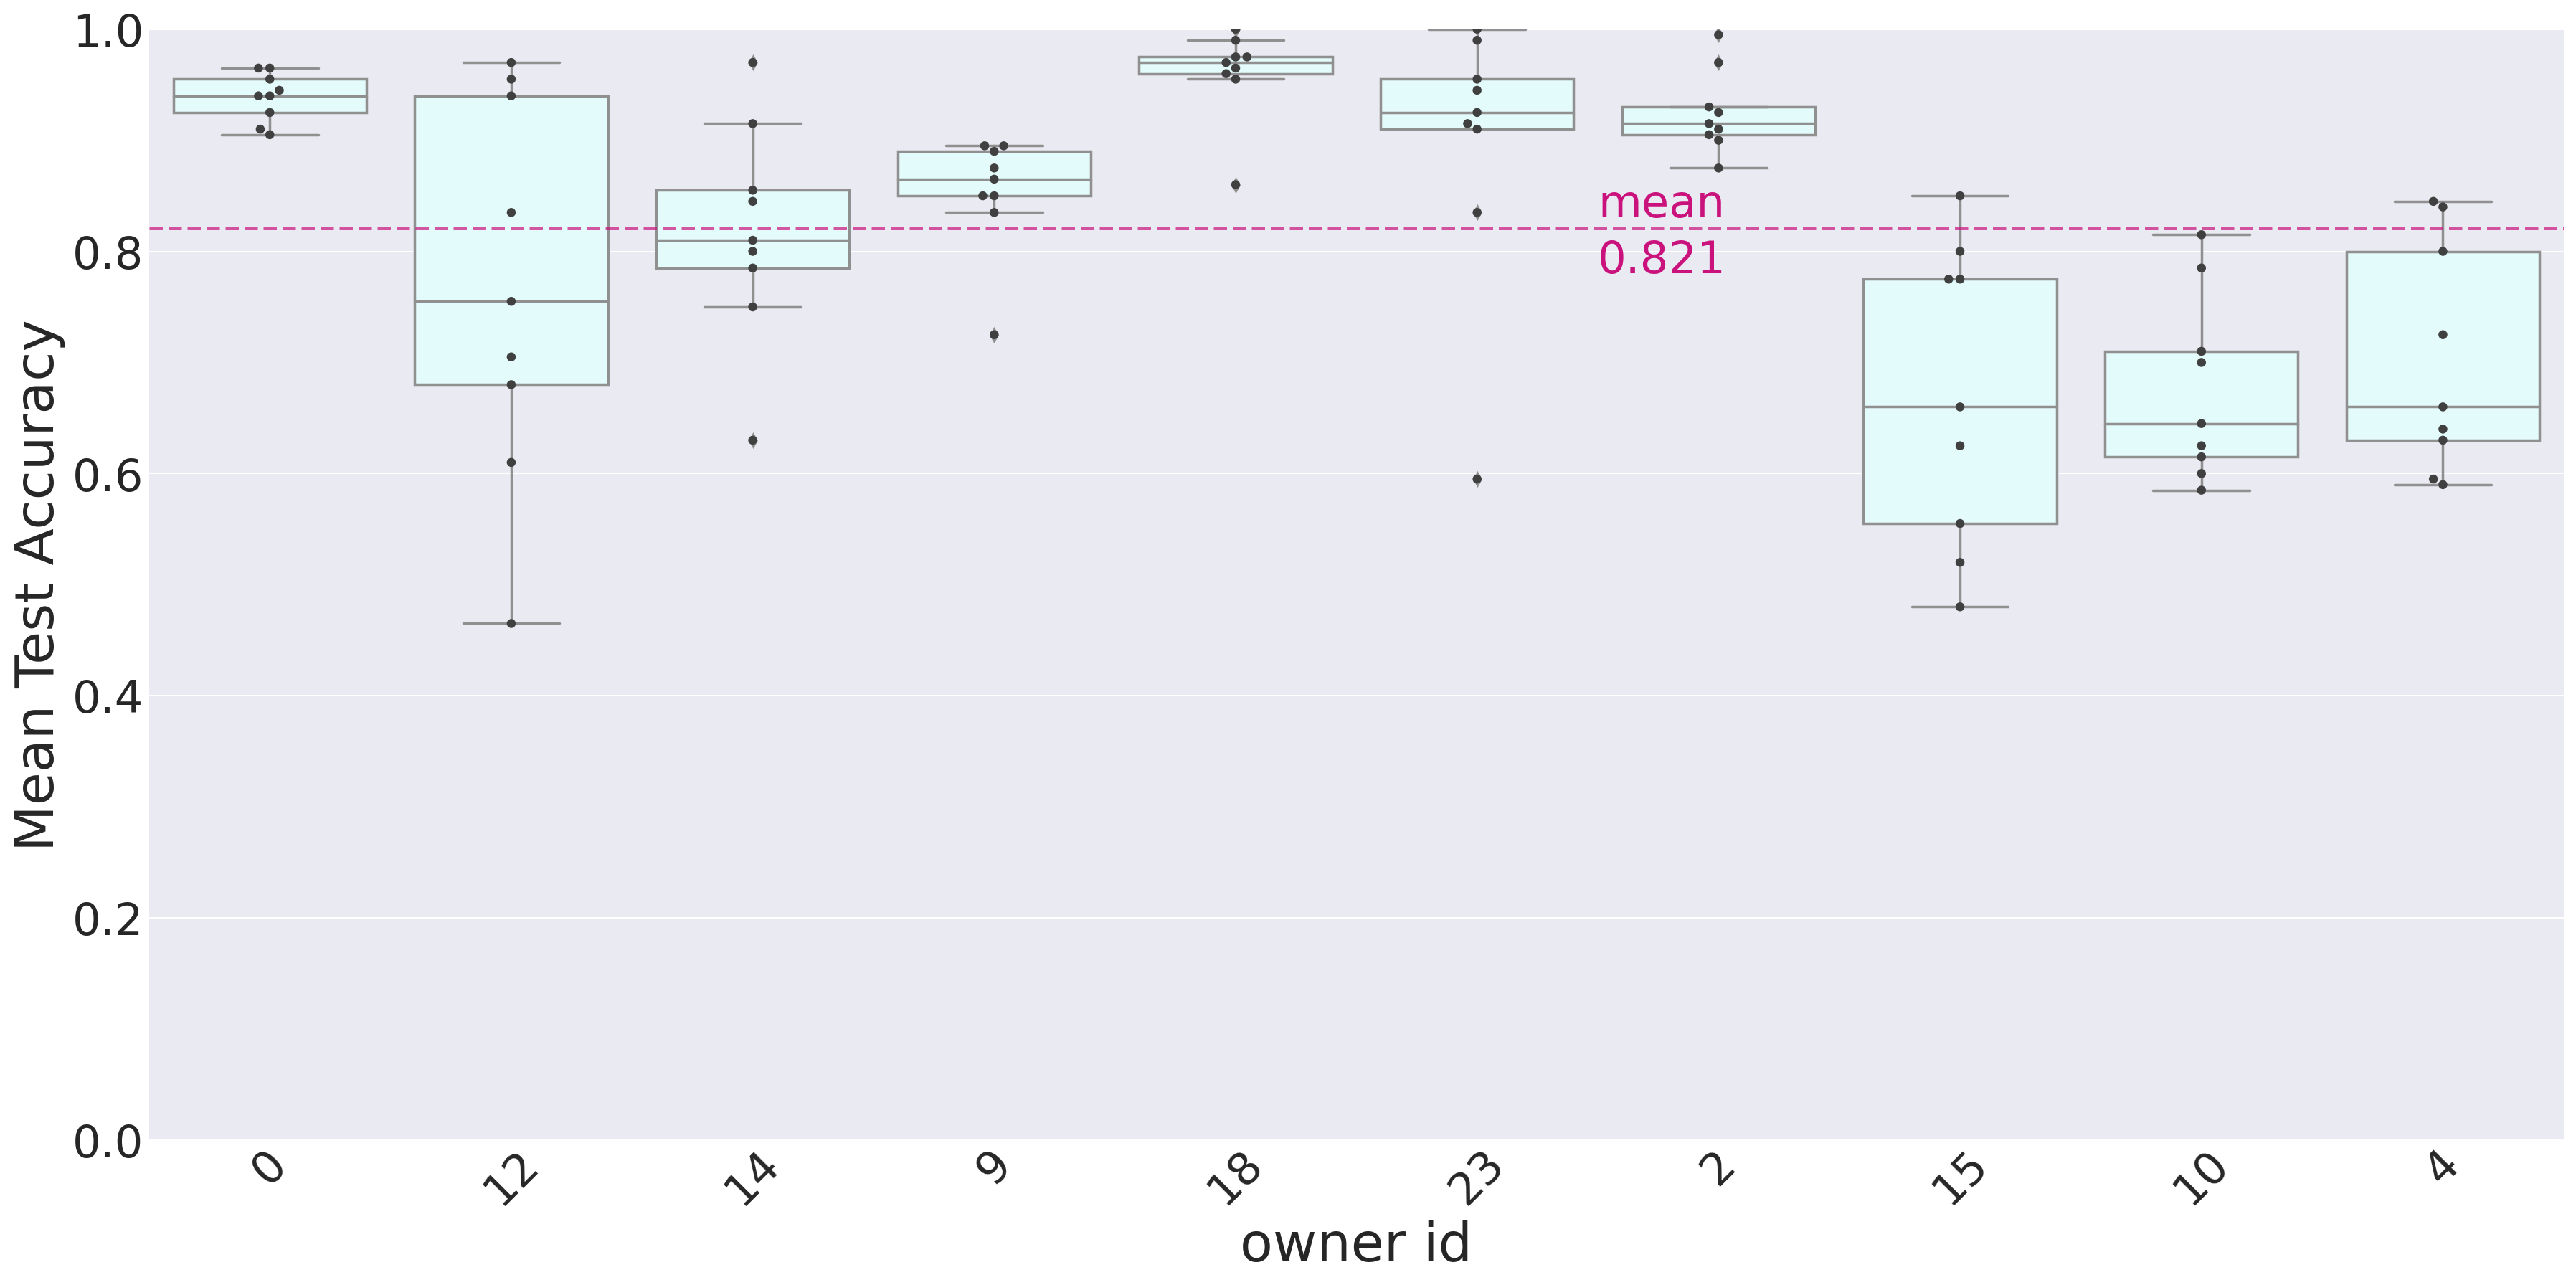

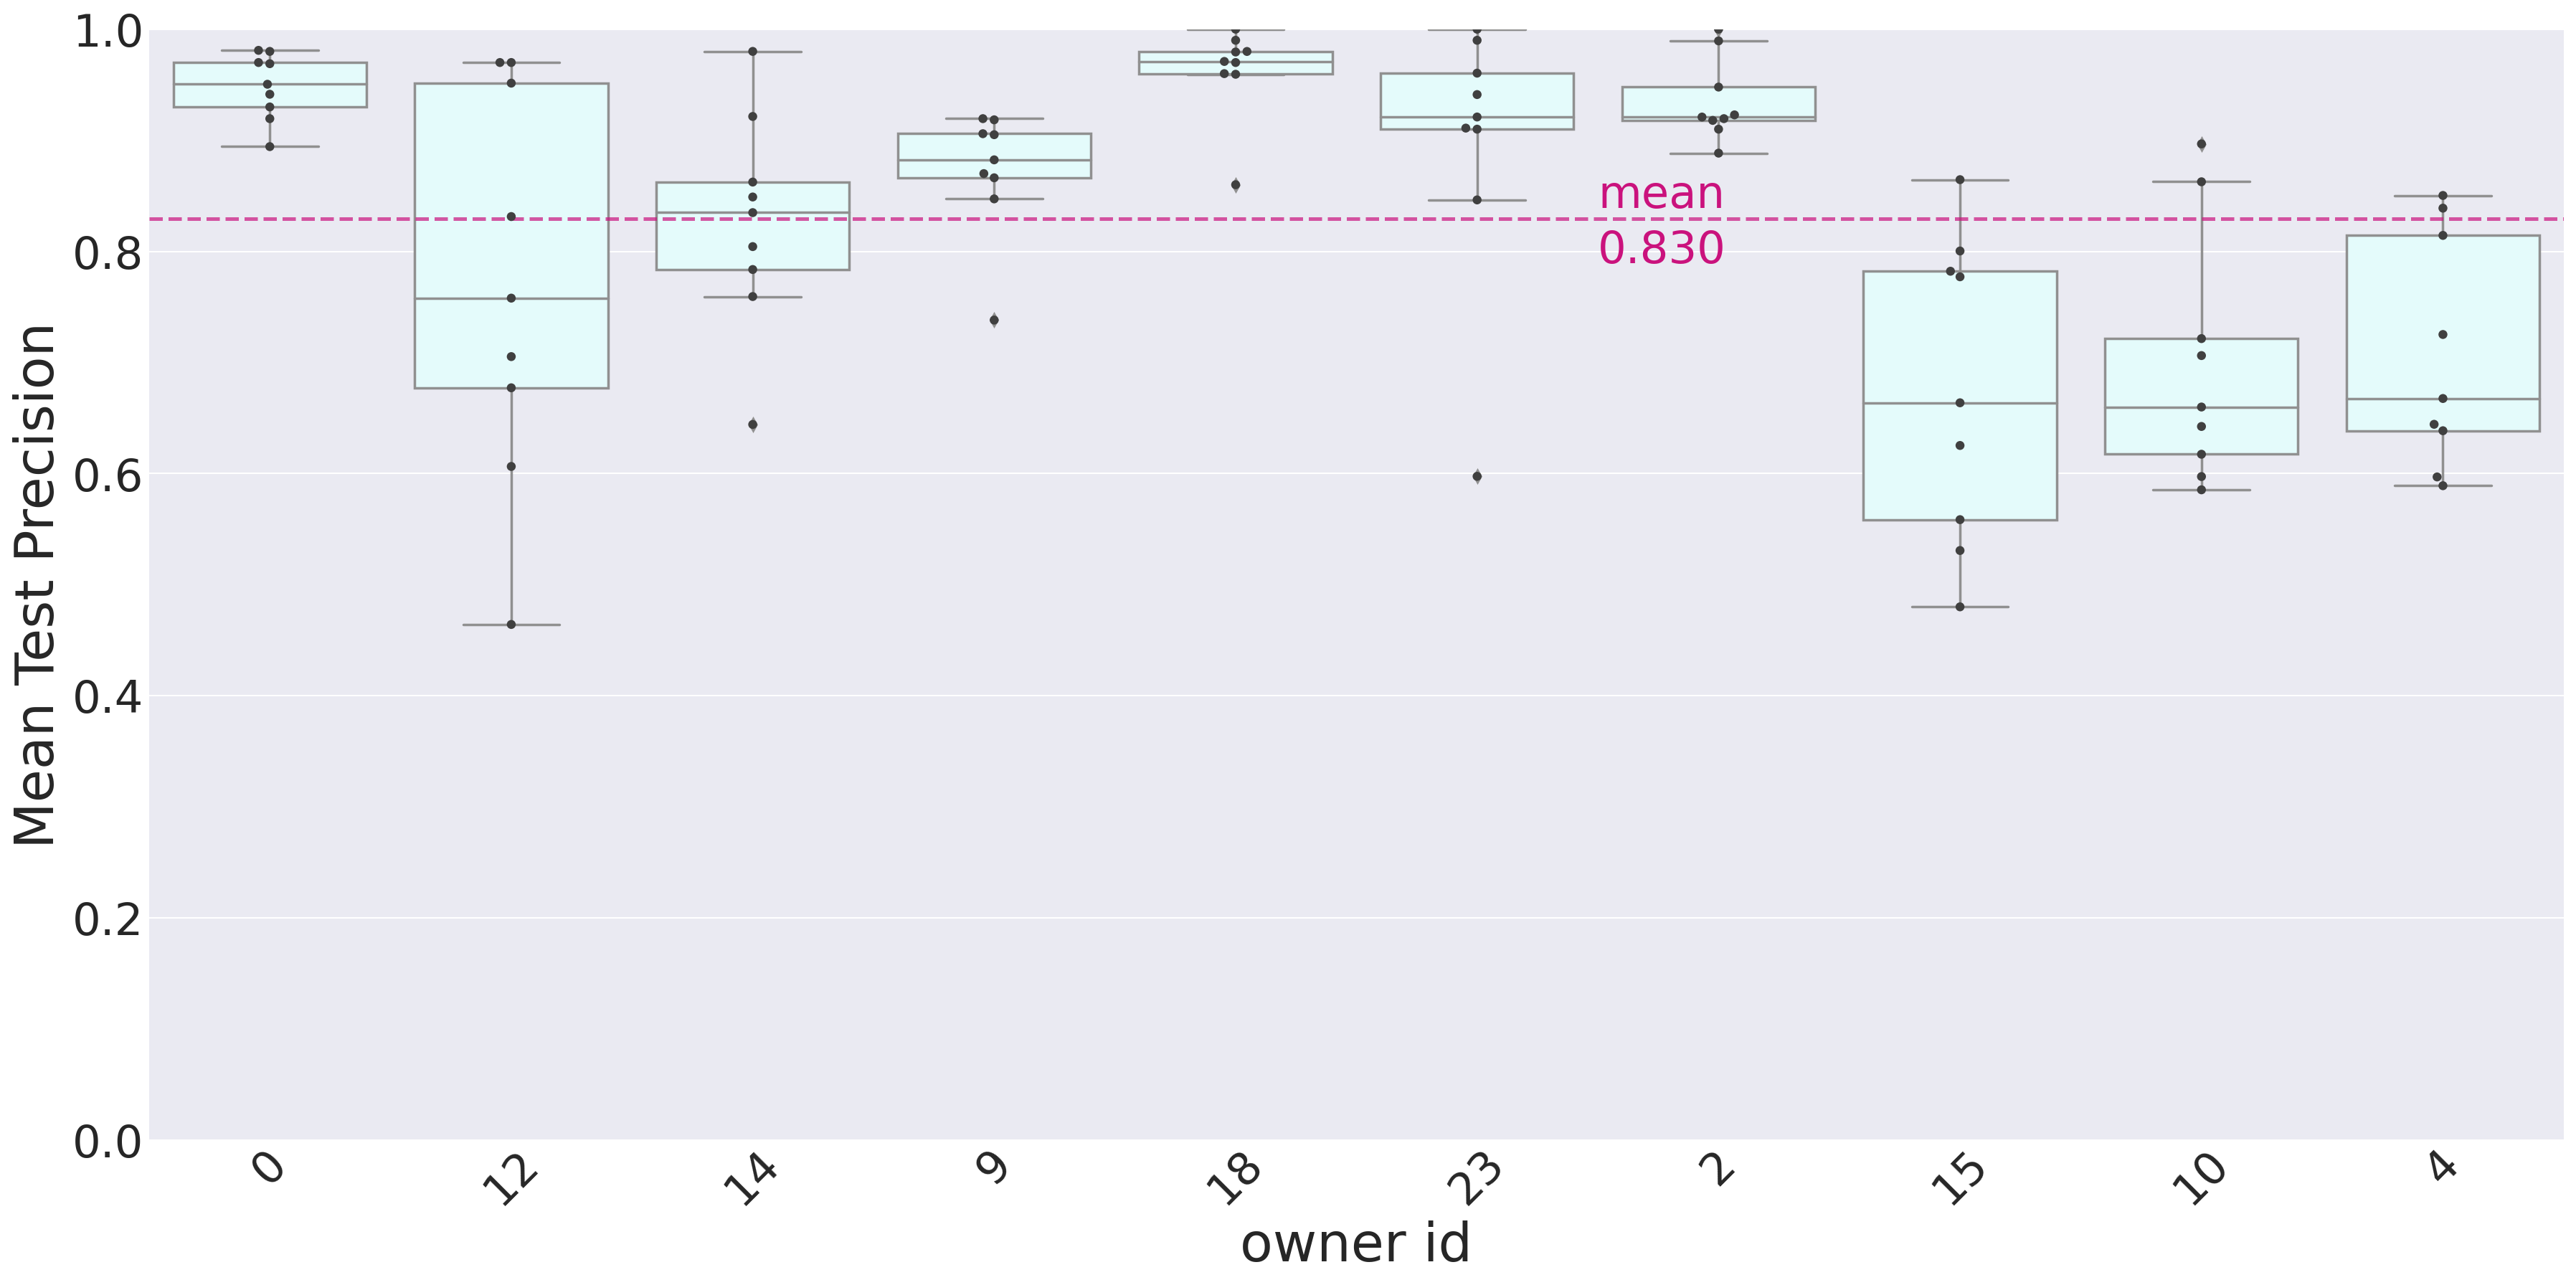

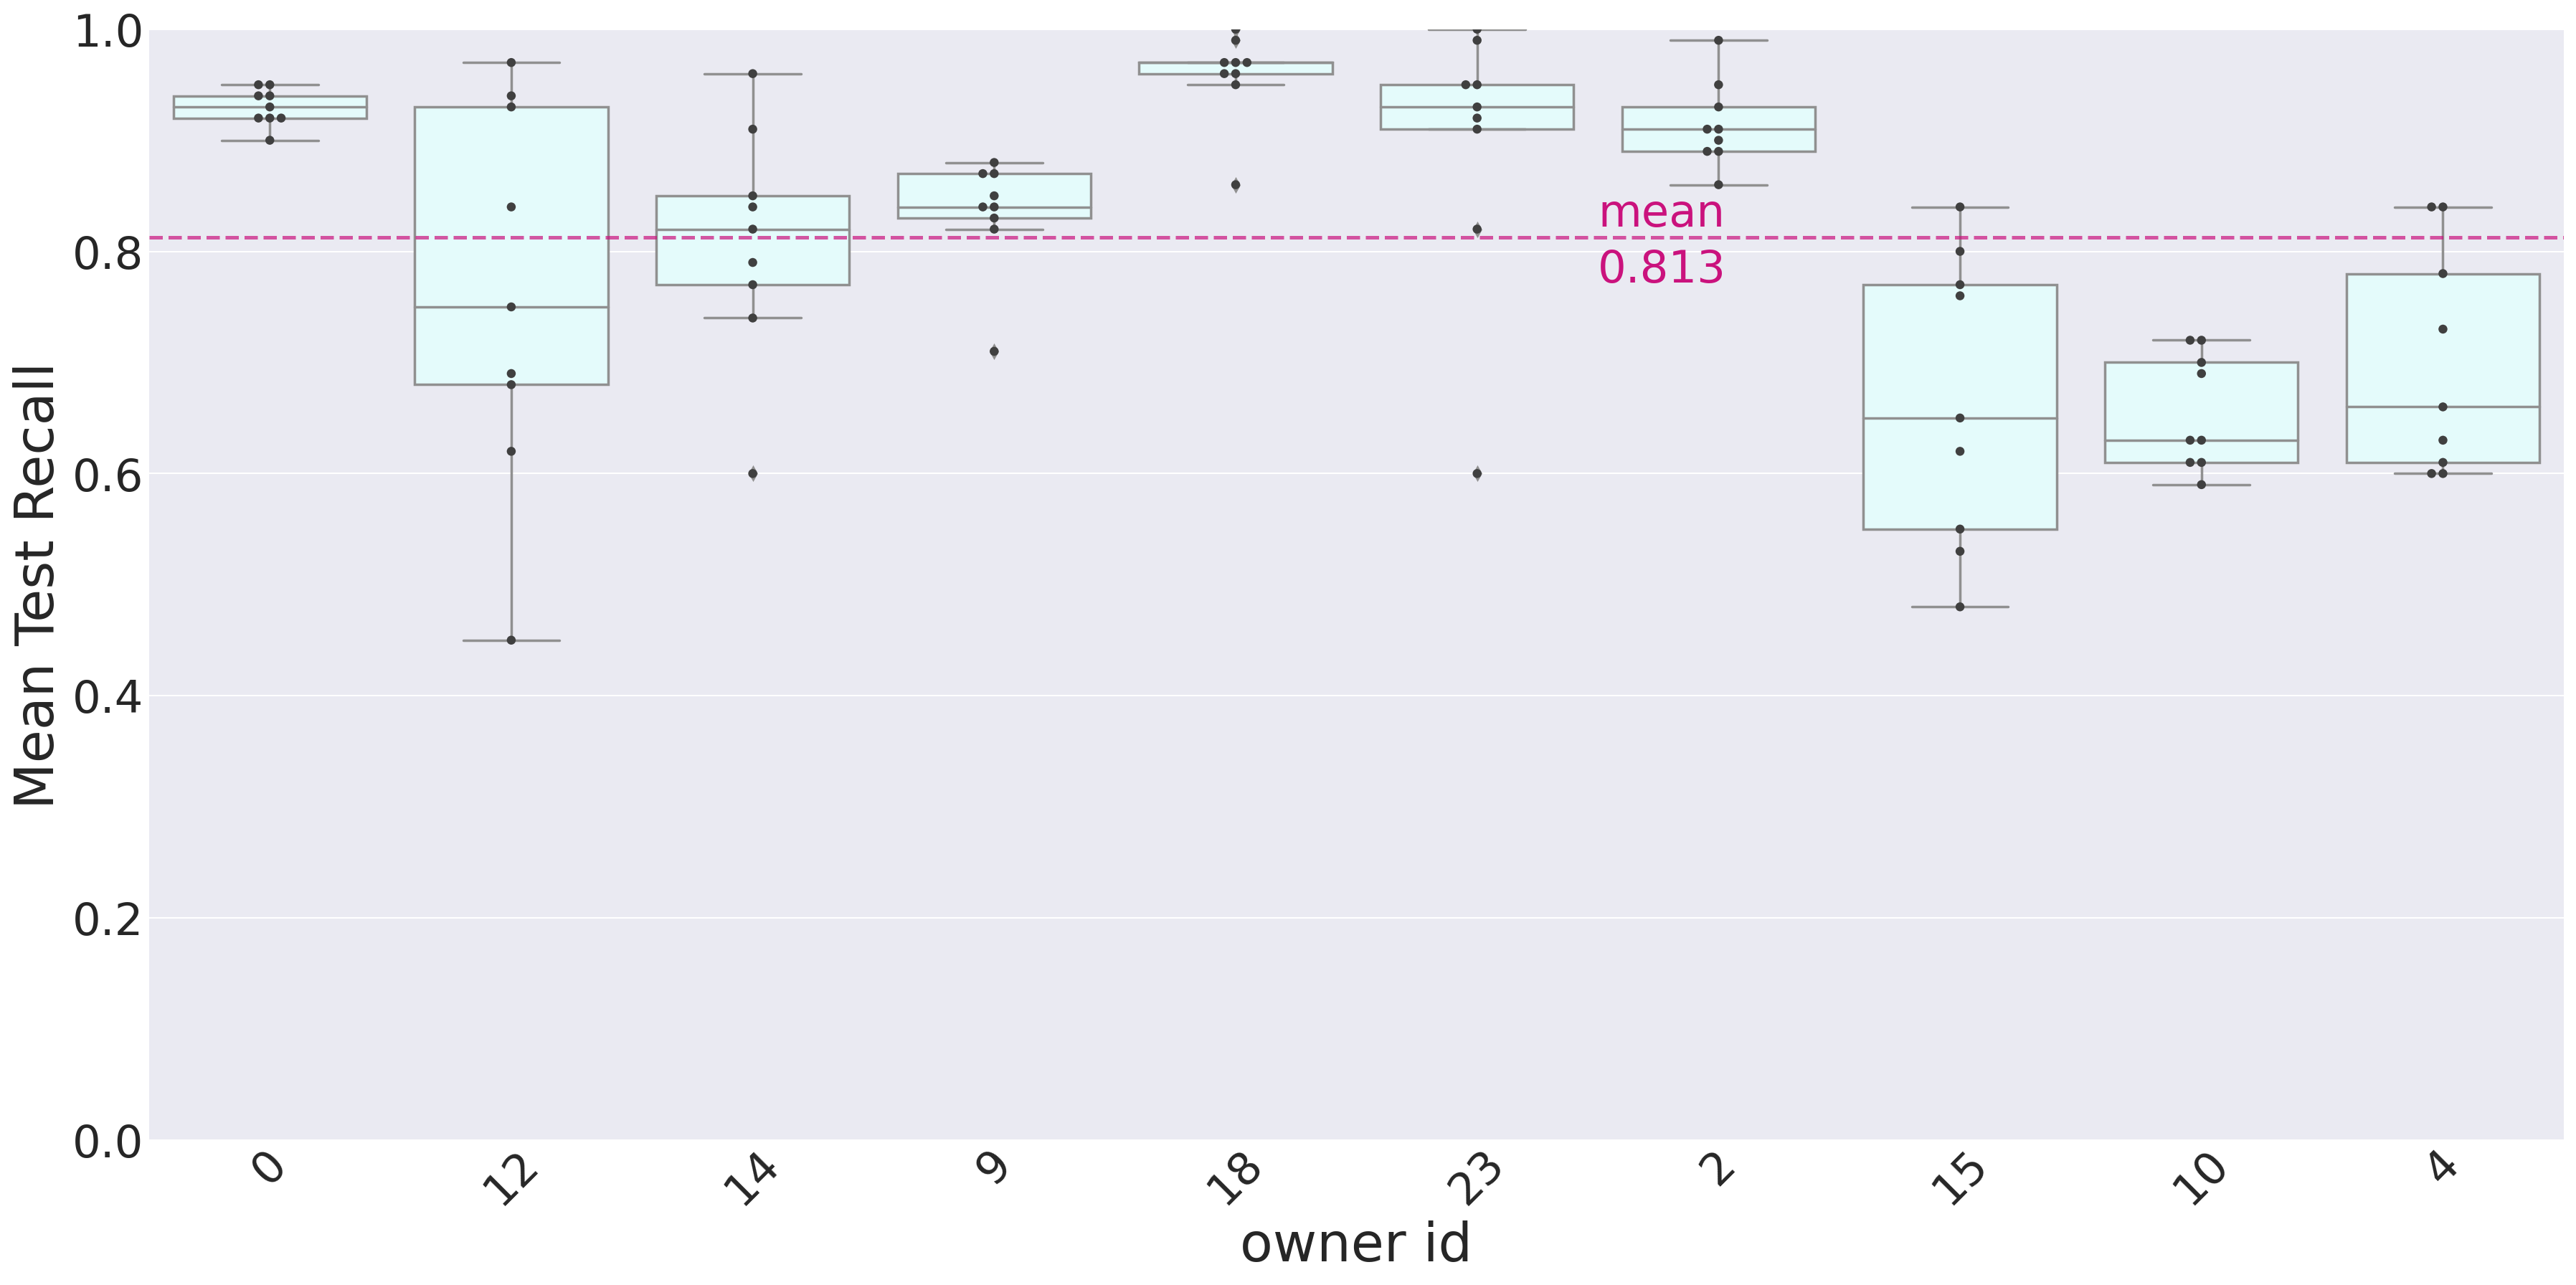

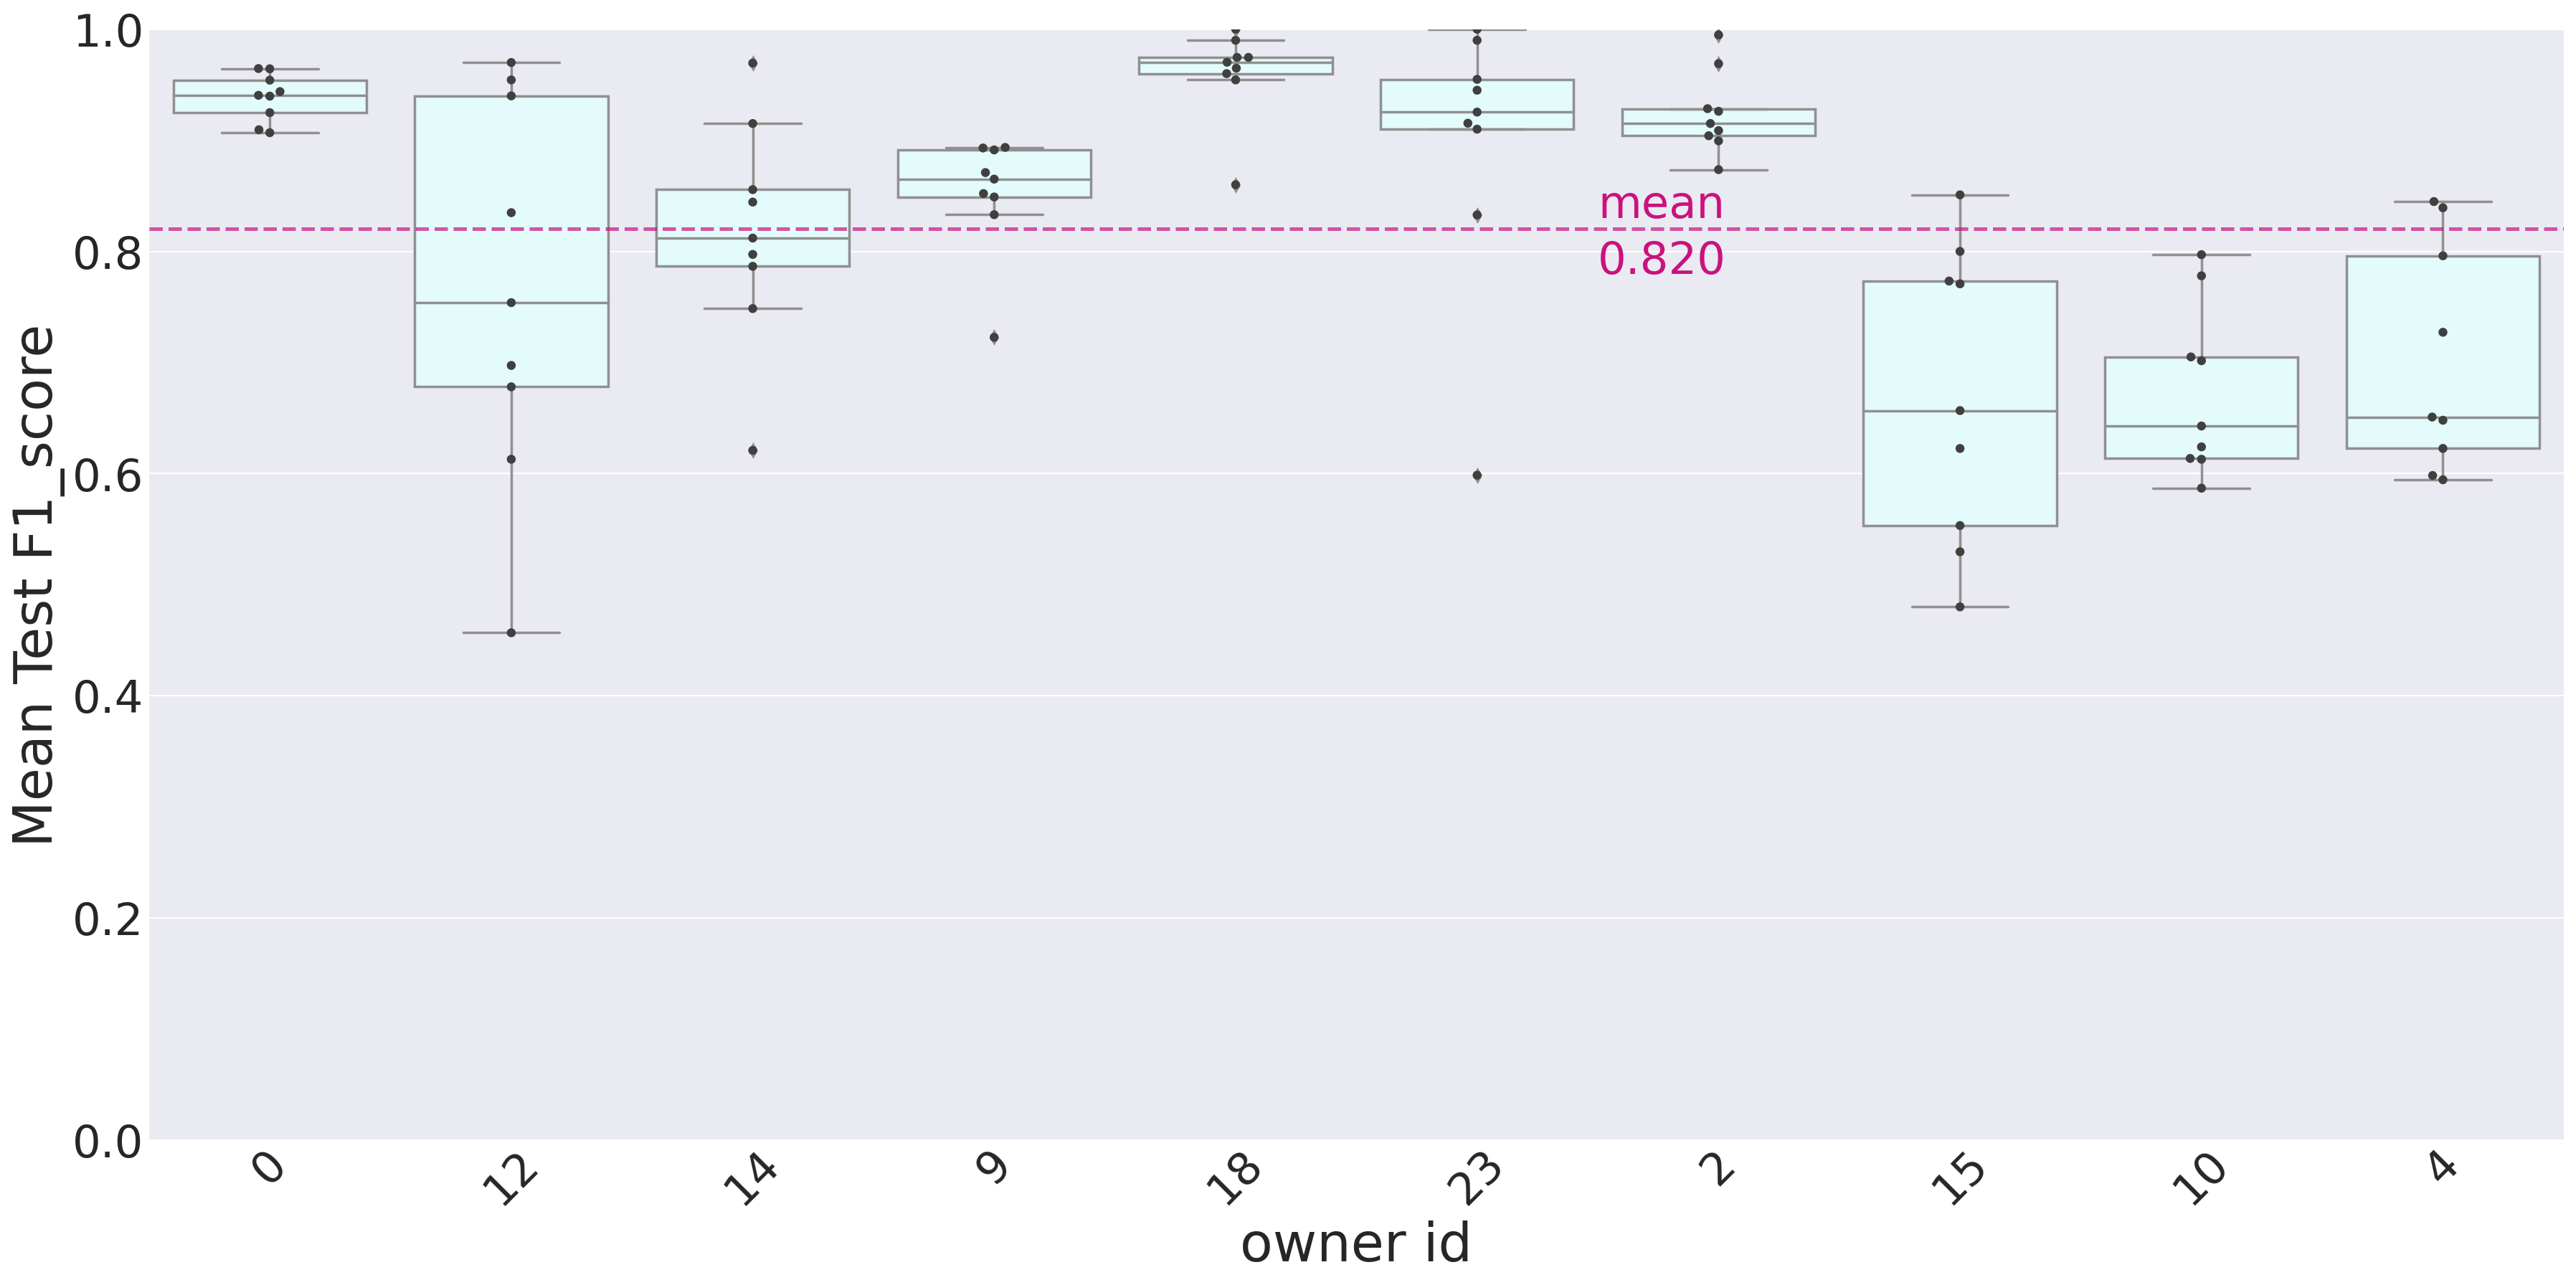

SEED: 567
--------------------SEED and CONSTANTS imported--------------------


In [41]:
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test EER', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_EER.svg")
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test Accuracy', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_Acc.svg")
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test Precision', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_Acc.svg")
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test Recall', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_Acc.svg")
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test F1_score', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_Acc.svg")

%run ./SEED-CONSTANTS.ipynb

In [ ]:
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test EER', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_EER.svg")
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test Accuracy', '', boxplot_color="lightcyan", save_file_name="WACA-OCSVM-750-Test_Acc.svg")

In [ ]:
print(gini(test_df_plot['Test EER'].to_numpy()))
lorenz_curve(test_df_plot['Test EER'].to_numpy())